# Import Package

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import cv2
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
import random
import pathlib

In [2]:
from IPython.display import Image

# Load Dataset

## Problem 1
- Image Path(train) : /dataset/train
- Image Path(test) : /dataset/test
- Image Path(valid) : /dataset/valid
- Image Size : Height X Width = 180 X 180
- Batch Size : 32
- percent of data as validation set : 20%

In [ ]:
data_dir = ?
batch_size = ?
img_height = ?
img_width = ?
train_ds = tf.keras.preprocessing.image_dataset_from_directory(?)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(?)
class_names = train_ds.class_names

# Data Visualization

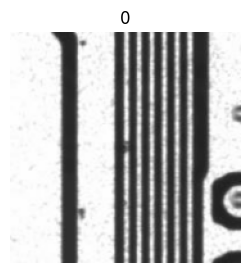

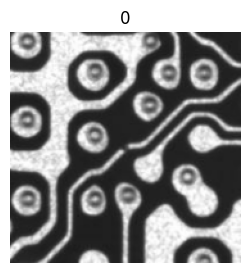

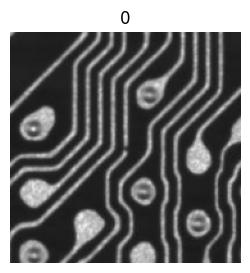

In [47]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    for i in range(3):
        plt.figure(figsize=(3, 3))
        plt.plot(1, 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        plt.show()

In [55]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


`image_batch`는 `(32, 180, 180, 3)` 형상의 텐서이며, `180x180x3` 형상의 32개 이미지 묶음으로 되어 있습니다(마지막 차원은 색상 채널 RGB를 나타냄). `label_batch`는 형상 `(32,)`의 텐서이며 32개 이미지에 해당하는 레이블입니다.

`image_batch` 및 `labels_batch` 텐서에서 `.numpy()`를 호출하여 이를 `numpy.ndarray`로 변환할 수 있습니다.


In [56]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Normalization 

In [57]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [58]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.094335556 0.8700315


# CNN Archetecture
![nn](./asset/simpleCNN_tensorflow.JPG)

# Build CNN

## Problem 2
- Image Rescale : Convert color scale from 0-255 to 0-1 range.
- Image Height : 180 , Image Width : 180 , channel : 3
- padding='same'
- activation='relu'
- Class = 2
- 위 4의 CNN 모델을 구성하시오

In [ ]:

model = Sequential([
  layers.experimental.preprocessing.Rescaling(?, input_shape=(?, ?, ?)),
  layers.Conv2D(?, ?, ?, ?),
  layers.MaxPooling2D(),
  layers.Conv2D(?, ?,  ?, ?),
  layers.MaxPooling2D(),
  layers.Conv2D(?, ?,  ?, ?),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(?, ?),  
  layers.Dense(?)
])

## Compile Model

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      128       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 64)       

## Train Model

In [ ]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

## Result

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict

## Problem 3
9개의 이미지를 Predict label과 Actual Label을 비교하여 표시하고 3 X 3의 형태로 이미지를 출력 하시오
- 아래 이미지는 출력 예시. 출력이미지와 Predict label이 같지 않아도 상관없습니다.
- valid 데이터셋은 ng폴더와 ok폴더로 구성되어 있습니다
- Image Height X Image Widht = 180 X 180
![simpleCNN_torch2](./asset/visual_torch.JPG)

In [ ]:
valid_path = glob("./dataset/valid/*/*")
num_images = 9
plt.figure(figsize=(15, 15))
for i, iPath in enumerate(valid_path[0:um_images]):
    img = keras.preprocessing.image.load_img(iPath, target_size=(?, ?))
    
    if "ng" in iPath:
        labels = 0        
    else:
        labels = 1        
    
    img_array = keras.preprocessing.image.img_to_array(?)
    img_array = tf.expand_dims(?, 0) 

    predictions = model.predict(?)
    score = tf.nn.sigmoid(?)

    ax = plt.subplot(?, ?, ?)
    plt.imshow(img)
    plt.title(f'Predict :{np.argmax(score)} ---- Actual : {labels}')   
    plt.axis("off")